In [5]:
import cv2
import numpy as np
import pandas as pd
import os
import sys
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from sklearn.metrics import classification_report
import shutil
from os import path
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

# path variables to access files
root = os.getcwd()
binary_root = os.path.join(root, "binary_task")
multiclass_root = os.path.join(root, "multiclass_task")

### Load dataframe

In [6]:
main_data = pd.read_csv("data_labels_mainData.csv")
extra_data = pd.read_csv("data_labels_extraData.csv")

### split data into different folders for different cell types

In [7]:
root = os.getcwd()
source_dir = os.path.join(root, "patch_images")

for i, row in main_data.iterrows():
    image_name = row["ImageName"]
    cell_name = row["cellTypeName"]
    is_cancer = str(row["isCancerous"])

#     new_folder_multi = os.path.join(root,"multiclass_task", cell_name)
    new_folder_bin = os.path.join(root,"binary_task", is_cancer)

#     os.makedirs(new_folder_multi, exist_ok=True)
    os.makedirs(new_folder_bin, exist_ok=True)

    source = os.path.join(source_dir, image_name)

#     dest_multi = os.path.join(root, "multiclass_task",cell_name)
    dest_bin = os.path.join(root,"binary_task", is_cancer)

#     go = shutil.copy(source,dest_multi)
    go = shutil.copy(source, dest_bin)

### Add training data for cancerous classification from extra dataset 

In [8]:
root = os.getcwd()
source_dir = os.path.join(root, "patch_images")

for i, row in extra_data.iterrows():
    image_name = row["ImageName"]
    is_cancer = str(row["isCancerous"])

    new_folder_bin = os.path.join(root, "binary_task",is_cancer)

    os.makedirs(new_folder_bin, exist_ok=True)

    source = os.path.join(source_dir, image_name)

    dest_bin = os.path.join(root, is_cancer)

    go = shutil.copy(source, dest_bin)

### Get data from splitted folder

In [19]:
root = os.getcwd()
source_dir = os.path.join(root, "patch_images")

# # method get data for binary task (task 1)
def cancerous_classify_data_all():    
    images = list()
    labels = list()
    
    for label in [0, 1]:
        # get image directory
        img_dir = os.path.join(root, "binary_task",f"{label}")
        
        for img in os.listdir(img_dir):
            img = cv2.imread(os.path.join(img_dir, img))
            # resize to 0-1 for faster computation
            resized = img / 255
            images.append(resized)
            labels.append(label)
        
    return (images, labels)

# all_class = ["epithelial", "fibroblast", "inflammatory", "others"]

# method get data for multiclass task (task 2)
def celltype_classify_data_all(class_list):    
    images = list()
    labels = list()
    
    for i, label in enumerate(class_list):
        # get image directory
        img_dir = os.path.join(root, "multiclass_task", f"{label}")
        
        for img in os.listdir(img_dir):
            img = cv2.imread(os.path.join(img_dir, img))
            # resize to 0-1 for faster computation
            resized = img / 255
            images.append(resized)
            labels.append(i)
        
    return (images, labels)


### New load file code

In [18]:
root = os.getcwd()
# method get data for binary task (task 1)
def cancerous_classify_data(mode):    
    images = list()
    labels = list()
    
    for label in [0, 1]:
        # get image directory
        img_dir = os.path.join(root, "split3-binary-task",f"{mode}",f"{label}")
        
        for img in os.listdir(img_dir):
            img = cv2.imread(os.path.join(img_dir, img))
            # resize to 0-1 for faster computation
            resized = img / 255
            images.append(resized)
            labels.append(label)
        
    return (images, labels)

all_class = ["epithelial", "fibroblast", "inflammatory", "others"]

# method get data for multiclass task (task 2)
def celltype_classify_data(class_list, mode):    
    images = list()
    labels = list()
    
    for i, label in enumerate(class_list):
        # get image directory
        img_dir = os.path.join(root, "split3-multi-task", f"{mode}", f"{label}")
        
        for img in os.listdir(img_dir):
            img = cv2.imread(os.path.join(img_dir, img))
            # resize to 0-1 for faster computation
            resized = img / 255
            images.append(resized)
            labels.append(i)
        
    return (images, labels)

### Classification report

In [11]:
def multiclass_classification_report(y_test, prediction):
    """
        Method to generate sklearn classification report with CNN multiclass output
    """
    
    encoded_pred = list()
    # convert each CNN output (sparse categorial) to class
    for pred in prediction:
        encoded_pred.append(np.argmax(pred))

    encoded_pred = np.array(encoded_pred)
    print(classification_report(y_test, encoded_pred))
    
def binary_classification_report(y_test, prediction):
    """
        Method to generate sklearn classification report with CNN binary output
    """
    encoded_pred = list()
    # convert each CNN output (sparse categorial) to class
    for pred in prediction:
        encoded_pred.append(round(pred[0]))

    encoded_pred = np.array(encoded_pred)
    print(classification_report(y_test, encoded_pred))

## I) Task 1 - Binary classification

### Load binary data

In [20]:
# # data being used
# images, cancer_label = cancerous_classify_data()

# # change to numpy
# images, cancer_label = np.array(images), np.array(cancer_label)
# print(images.shape)
# print(cancer_label.shape)

# # generate train, validation and test set
# x_train_val, x_test, y_train_val, y_test = train_test_split(
#     images, cancer_label, test_size=0.2
# )
# x_train, x_val, y_train, y_val = train_test_split(
#     x_train_val, y_train_val, test_size=0.25
# )

images, cancer_label = cancerous_classify_data_all()

x_train, y_train = cancerous_classify_data("train")
x_train, y_train = np.array(x_train), np.array(y_train)

x_val, y_val = cancerous_classify_data("val")
x_val, y_val = np.array(x_val), np.array(y_val)

x_test, y_test = cancerous_classify_data("test")
x_test, y_test = np.array(x_test), np.array(y_test)

### Base CNN model

In [13]:
def get_model():
    model = tf.keras.Sequential()
    # First convo-pooling
    # Convolutional layers (filter the image with a kernel)
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=[27, 27, 3]))
    # Max-pooling layers (reduce the size of the image by choosing max pixel at certain area)
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    # Flatten input
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(128, activation="relu"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    # Output layer
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    # Compile model
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy", "AUC"])
    return model

binary_model = get_model()
binary_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Metal device set to: Apple M1 Pro
Epoch 1/10


2022-05-12 17:04:54.431478: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-12 17:04:54.431585: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-12 17:04:54.553911: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-12 17:04:54.740575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


381/381 [==============================] - ETA: 0s - loss: 0.4421 - accuracy: 0.7893 - auc: 0.8590

2022-05-12 17:04:58.498163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


381/381 [==============================] - 5s 11ms/step - loss: 0.4421 - accuracy: 0.7893 - auc: 0.8590 - val_loss: 0.3595 - val_accuracy: 0.8422 - val_auc: 0.9142
Epoch 2/10
381/381 [==============================] - 4s 11ms/step - loss: 0.3616 - accuracy: 0.8418 - auc: 0.9091 - val_loss: 0.3537 - val_accuracy: 0.8459 - val_auc: 0.9201
Epoch 3/10
381/381 [==============================] - 4s 11ms/step - loss: 0.3467 - accuracy: 0.8512 - auc: 0.9166 - val_loss: 0.3297 - val_accuracy: 0.8547 - val_auc: 0.9270
Epoch 4/10
381/381 [==============================] - 4s 11ms/step - loss: 0.3340 - accuracy: 0.8586 - auc: 0.9225 - val_loss: 0.3352 - val_accuracy: 0.8545 - val_auc: 0.9319
Epoch 5/10
381/381 [==============================] - 4s 10ms/step - loss: 0.3233 - accuracy: 0.8622 - auc: 0.9279 - val_loss: 0.3127 - val_accuracy: 0.8691 - val_auc: 0.9344
Epoch 6/10
381/381 [==============================] - 4s 10ms/step - loss: 0.3177 - accuracy: 0.8627 - auc: 0.9304 - val_loss: 0.3406 - 

In [14]:
binary_pred = binary_model.predict(x_test)
binary_classification_report(y_test, binary_pred)

2022-05-12 17:05:35.292602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.89      0.92      0.90      2643
           1       0.84      0.79      0.81      1415

    accuracy                           0.87      4058
   macro avg       0.87      0.85      0.86      4058
weighted avg       0.87      0.87      0.87      4058



### CNN with ZCA whitening

In [15]:
# get zca whitening data
datagen = ImageDataGenerator(
    zca_whitening=True,
)
datagen.fit(images)

zca_aug_train = datagen.flow(x_train, y_train, shuffle=True)
zca_aug_val = datagen.flow(x_val, y_val, shuffle=True)

zca_binary = get_model()
zca_binary.fit(zca_aug_train, epochs=10, validation_data=zca_aug_val)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


NameError: name 'images' is not defined

In [ ]:
zca_aug_test = datagen.flow(x_test, shuffle=False)
zca_binary_pred = zca_binary.predict_generator(zca_aug_test)

binary_classification_report(y_test, zca_binary_pred)

### CNN with rotation

In [21]:
# get rotation data
datagen = ImageDataGenerator(
    rotation_range=45,
)
datagen.fit(images)

aug_train = datagen.flow(x_train, y_train, shuffle=True)
aug_val = datagen.flow(x_val, y_val, shuffle=True)

rotation_binary = get_model()
rotation_binary.fit(aug_train, epochs=10, validation_data=aug_val)

Epoch 1/10
  1/381 [..............................] - ETA: 2:07 - loss: 0.8056 - accuracy: 0.3438 - auc: 0.4264

2022-05-12 17:17:13.913480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


380/381 [============================>.] - ETA: 0s - loss: 0.4341 - accuracy: 0.7946 - auc: 0.8635

2022-05-12 17:17:17.565521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


381/381 [==============================] - 5s 11ms/step - loss: 0.4338 - accuracy: 0.7946 - auc: 0.8638 - val_loss: 0.4186 - val_accuracy: 0.8185 - val_auc: 0.9103
Epoch 2/10
381/381 [==============================] - 4s 11ms/step - loss: 0.3655 - accuracy: 0.8409 - auc: 0.9065 - val_loss: 0.3599 - val_accuracy: 0.8446 - val_auc: 0.9222
Epoch 3/10
381/381 [==============================] - 4s 11ms/step - loss: 0.3575 - accuracy: 0.8452 - auc: 0.9107 - val_loss: 0.3386 - val_accuracy: 0.8557 - val_auc: 0.9245
Epoch 4/10
381/381 [==============================] - 4s 11ms/step - loss: 0.3484 - accuracy: 0.8488 - auc: 0.9155 - val_loss: 0.3373 - val_accuracy: 0.8570 - val_auc: 0.9303
Epoch 5/10
381/381 [==============================] - 4s 11ms/step - loss: 0.3396 - accuracy: 0.8532 - auc: 0.9199 - val_loss: 0.3423 - val_accuracy: 0.8498 - val_auc: 0.9313
Epoch 6/10
381/381 [==============================] - 4s 11ms/step - loss: 0.3296 - accuracy: 0.8567 - auc: 0.9245 - val_loss: 0.3071 - 

In [22]:
aug_test = datagen.flow(x_test, shuffle=False)

rotation_pred = rotation_binary.predict_generator(aug_test)
binary_classification_report(y_test, rotation_pred)

/var/folders/bc/1x56pk_j3glgqwsdp02fbltm0000gn/T/ipykernel_66614/786871663.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  rotation_pred = rotation_binary.predict_generator(aug_test)
2022-05-12 17:17:55.291936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.84      0.96      0.90      2643
           1       0.91      0.66      0.77      1415

    accuracy                           0.86      4058
   macro avg       0.87      0.81      0.83      4058
weighted avg       0.86      0.86      0.85      4058



### Tune CNN model

**Parameters that affect the output of models:**
- Size of kernel of Convolution/Pooling Layers
- Strides of Convolution/Pooling Layers
- Activation function

**Other aspects that would affect the output of models**
- Number of Convolution/Pooling layers
- Number of hidden layer

**Method of tuning**: for this problem, the tuning being applied is RandomSearch as there are many combinations to adjust the model. The tuning progress would be carried out both manually and by using keras tuner

In [23]:
def cnn_tuner(hp):
    model = tf.keras.Sequential()

    for i in range(hp.Int(f'no_cnn', 1, 4, step=1)):
        # Convolutional layers (filter the image with a kernel)
        model.add(tf.keras.layers.Conv2D(hp.Int(f'convo_filter_{i}', 16, 128, step=16), (3, 3), strides=1,activation=hp.Choice(f"activation_convo_{i}", ["relu", "sigmoid", "softmax", "tanh"]), input_shape=[27, 27, 3]))
        # Max-pooling layers (reduce the size of the image by choosing max pixel at certain area)
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=1,))
        
    # Flatten input
    model.add(tf.keras.layers.Flatten())

    # hidden layers
    for i in range(hp.Int('layers_no', 1, 4)):
        model.add(tf.keras.layers.Dense(hp.Int(f'hidden_layer_{i}', 32, 256, step=32), activation=hp.Choice(f"activation_hidden_{i}", ["relu", "sigmoid", "softmax", "tanh"])))
        
    # output layer
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))   
    # Compile model
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy", "AUC"])
    
    return model
              
tuner = kt.RandomSearch(cnn_tuner, objective="val_accuracy", max_trials=5)

tuner.search(x_train, y_train, epochs=5, validation_data=(x_val, y_val))
best_model = tuner.get_best_models()[0]

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [24]:
# print(f"Best Convolution filter: {tuner.get_best_hyperparameters()[0].get('convo_filter')}")
print(f"Best number of CNN layer: {tuner.get_best_hyperparameters()[0].get('no_cnn')}")
print(f"Best number of hidden layer: {tuner.get_best_hyperparameters()[0].get('layers_no')}")

for i in range(tuner.get_best_hyperparameters()[0].get('no_cnn')):
    print(f"Best filter in CNN layer {i}: {tuner.get_best_hyperparameters()[0].get(f'convo_filter_{i}')}")
    print(f"Best activation in CNN layer {i}: {tuner.get_best_hyperparameters()[0].get(f'activation_convo_{i}')}")

for i in range(tuner.get_best_hyperparameters()[0].get('layers_no')):
    print(f"Best nodes in hidden layer {i}: {tuner.get_best_hyperparameters()[0].get(f'hidden_layer_{i}')}")
    print(f"Best activation in hidden layer {i}: {tuner.get_best_hyperparameters()[0].get(f'activation_hidden_{i}')}")

Best number of CNN layer: 4
Best number of hidden layer: 2
Best filter in CNN layer 0: 32
Best activation in CNN layer 0: relu
Best filter in CNN layer 1: 48
Best activation in CNN layer 1: relu
Best filter in CNN layer 2: 16
Best activation in CNN layer 2: relu
Best filter in CNN layer 3: 16
Best activation in CNN layer 3: relu
Best nodes in hidden layer 0: 192
Best activation in hidden layer 0: relu
Best nodes in hidden layer 1: 128
Best activation in hidden layer 1: sigmoid


In [25]:
best_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10


2022-05-12 17:17:56.380790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


381/381 [==============================] - ETA: 0s - loss: 0.3416 - accuracy: 0.8526 - auc: 0.9191

2022-05-12 17:18:01.684912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


381/381 [==============================] - 7s 16ms/step - loss: 0.3416 - accuracy: 0.8526 - auc: 0.9191 - val_loss: 0.3350 - val_accuracy: 0.8615 - val_auc: 0.9304
Epoch 2/10
381/381 [==============================] - 5s 14ms/step - loss: 0.3330 - accuracy: 0.8557 - auc: 0.9231 - val_loss: 0.3070 - val_accuracy: 0.8753 - val_auc: 0.9347
Epoch 3/10
381/381 [==============================] - 6s 15ms/step - loss: 0.3165 - accuracy: 0.8662 - auc: 0.9307 - val_loss: 0.3364 - val_accuracy: 0.8605 - val_auc: 0.9273
Epoch 4/10
381/381 [==============================] - 6s 15ms/step - loss: 0.3120 - accuracy: 0.8667 - auc: 0.9324 - val_loss: 0.3054 - val_accuracy: 0.8817 - val_auc: 0.9399
Epoch 5/10
381/381 [==============================] - 5s 14ms/step - loss: 0.3096 - accuracy: 0.8657 - auc: 0.9337 - val_loss: 0.3218 - val_accuracy: 0.8620 - val_auc: 0.9337
Epoch 6/10
381/381 [==============================] - 6s 15ms/step - loss: 0.2998 - accuracy: 0.8737 - auc: 0.9378 - val_loss: 0.3033 - 

In [26]:
binary_tuned_pred = best_model.predict(x_test)
binary_classification_report(y_test, binary_tuned_pred)

2022-05-12 17:18:52.572528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.93      0.84      0.89      2643
           1       0.75      0.89      0.82      1415

    accuracy                           0.86      4058
   macro avg       0.84      0.87      0.85      4058
weighted avg       0.87      0.86      0.86      4058



### Ensemble model

In [27]:
# intialize and train sub-models
def get_sub_model():
    # number of sub models
    nets = 5
    sub_models = [0]*nets
    model_path = os.path.join(root, "binary_submodels")
    
    if not path.exists(model_path) or len(os.listdir(model_path))!=nets:
        for i in range(nets):
            model = get_model()
            # fit sub_model with train and test data
            model.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))
            # save fitted sub_model to model list
            sub_models[i] = model
            
            # new file dir
            new_dir = os.path.join(model_path, f'submodel_{i}.h5')
            # save model to file
            model.save(new_dir)
        return sub_models
    else:
        for i in range(nets):
            sub_models[i]=keras.models.load_model(os.path.join(model_path, f'submodel_{i}.h5'))
        
        return sub_models
    
sub_models = get_sub_model()

In [28]:
# method to get output from submodels to feed meta_learner
# shape of dataset would be (no rows of OG dataset, [no output of sub model * no sub model])
def get_ensembled_x(x):
    ensembled_data = None
    for sub_model in sub_models:
        prediction = sub_model.predict(x)
        
        # stack prediction of sub model to ensembled data
        if ensembled_data is None:
            ensembled_data = prediction
        else:
            ensembled_data = np.dstack((ensembled_data, prediction))
            
    # ensemble data initially shape iz (no_col, no submodels, no classes)        
    # reshape to (no_col, no submodels*no classes)
    ensembled_data = ensembled_data.reshape(ensembled_data.shape[0], ensembled_data.shape[1]*ensembled_data.shape[2])
    return ensembled_data

def get_meta_learner():
    model = tf.keras.Sequential()
    # Flatten input
    model.add(tf.keras.layers.Flatten())
    # Hidden layers
    model.add(tf.keras.layers.Dense(256, activation="tanh"))
    model.add(tf.keras.layers.Dense(128, activation="softmax"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    # Output layer
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    # Compile model
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy", "AUC"])
    
    # get train ensembled data
    ensembled_x = get_ensembled_x(x_train)
    
    model.fit(ensembled_x, y_train, epochs=10)
    return model 

In [29]:
# evaluate with ensembled CNN model
# get test data
ensembled_x_test = get_ensembled_x(x_test)
# get trained ensemble model
ensembled_model = get_meta_learner()

2022-05-12 17:18:53.217968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 17:18:53.461112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 17:18:53.705868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 17:18:53.951823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 17:18:54.192018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10
  1/381 [..............................] - ETA: 2:10 - loss: 0.6923 - accuracy: 0.6250 - auc: 0.5000

2022-05-12 17:18:57.614110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


381/381 [==============================] - 3s 8ms/step - loss: 0.4395 - accuracy: 0.8217 - auc: 0.8757
Epoch 2/10
381/381 [==============================] - 3s 8ms/step - loss: 0.3454 - accuracy: 0.8506 - auc: 0.9199
Epoch 3/10
381/381 [==============================] - 3s 8ms/step - loss: 0.3396 - accuracy: 0.8521 - auc: 0.9218
Epoch 4/10
381/381 [==============================] - 3s 8ms/step - loss: 0.3384 - accuracy: 0.8520 - auc: 0.9223
Epoch 5/10
381/381 [==============================] - 3s 8ms/step - loss: 0.3380 - accuracy: 0.8520 - auc: 0.9220
Epoch 6/10
381/381 [==============================] - 3s 8ms/step - loss: 0.3354 - accuracy: 0.8514 - auc: 0.9235
Epoch 7/10
381/381 [==============================] - 3s 8ms/step - loss: 0.3327 - accuracy: 0.8543 - auc: 0.9245
Epoch 8/10
381/381 [==============================] - 3s 8ms/step - loss: 0.3325 - accuracy: 0.8540 - auc: 0.9243
Epoch 9/10
381/381 [==============================] - 3s 8ms/step - loss: 0.3329 - accuracy: 0.8529

In [30]:
# evaluate
ensemble_pred = ensembled_model.predict(ensembled_x_test)
binary_classification_report(y_test, ensemble_pred)

2022-05-12 17:19:28.226646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.89      0.88      0.89      2643
           1       0.78      0.81      0.79      1415

    accuracy                           0.85      4058
   macro avg       0.84      0.84      0.84      4058
weighted avg       0.85      0.85      0.85      4058



## II) Task 2 - Multiclasses classification


### Load data for multiclasses

In [51]:
# all_class = ["epithelial", "fibroblast", "inflammatory", "others"]
cell_img, celltype_label = celltype_classify_data_all(all_class)
cell_img, celltype_label = np.array(cell_img), np.array(celltype_label)

# x_train_val, x_test, y_train_val, y_test = train_test_split(
#     cell_img, celltype_label, test_size=0.2
# )

# x_train, x_val, y_train, y_val = train_test_split(
#     x_train_val, y_train_val, test_size=0.25
# )

x_train, y_train = celltype_classify_data(all_class, "train")
x_train, y_train = np.array(x_train), np.array(y_train)

x_val, y_val = celltype_classify_data(all_class, "val")
x_val, y_val = np.array(x_val), np.array(y_val)

x_test, y_test = celltype_classify_data(all_class, "test")
x_test, y_test = np.array(x_test), np.array(y_test)


### Base model for multiclass  

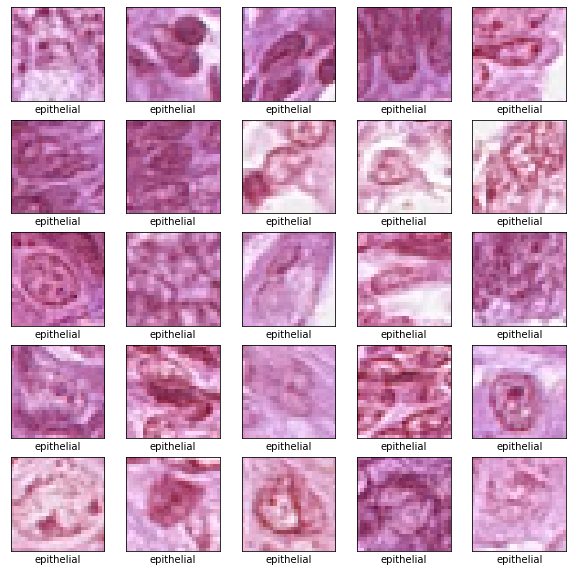

Epoch 1/15


2022-05-12 18:34:39.800423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


186/186 [==============================] - ETA: 0s - loss: 1.1134 - accuracy: 0.5495

2022-05-12 18:34:42.807749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


186/186 [==============================] - 4s 17ms/step - loss: 1.1134 - accuracy: 0.5495 - val_loss: 1.0746 - val_accuracy: 0.5589
Epoch 2/15
186/186 [==============================] - 3s 15ms/step - loss: 0.8586 - accuracy: 0.6596 - val_loss: 0.8000 - val_accuracy: 0.6884
Epoch 3/15
186/186 [==============================] - 3s 15ms/step - loss: 0.7795 - accuracy: 0.6925 - val_loss: 0.8060 - val_accuracy: 0.6884
Epoch 4/15
186/186 [==============================] - 3s 15ms/step - loss: 0.7404 - accuracy: 0.7048 - val_loss: 0.7475 - val_accuracy: 0.7233
Epoch 5/15
186/186 [==============================] - 3s 15ms/step - loss: 0.7308 - accuracy: 0.7100 - val_loss: 0.7241 - val_accuracy: 0.7218
Epoch 6/15
186/186 [==============================] - 3s 15ms/step - loss: 0.6698 - accuracy: 0.7390 - val_loss: 0.7076 - val_accuracy: 0.7294
Epoch 7/15
186/186 [==============================] - 3s 15ms/step - loss: 0.6479 - accuracy: 0.7466 - val_loss: 0.7013 - val_accuracy: 0.7395
Epoch 8/15

In [81]:

# print first 25 images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(all_class[y_train[i]])
plt.show()

def get_multiclass_model():
    model = tf.keras.Sequential()
    # First convo-pooling
    # Convolutional layers (filter the image with a kernel)
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=1,activation="relu", input_shape=[27, 27, 3]))
    # Max-pooling layers (reduce the size of the image by choosing max pixel at certain area)
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=1))
    
    # Second convo-pooling
    # Convolutional layers (filter the image with a kernel)
    model.add(tf.keras.layers.Conv2D(64, (3, 3),strides=1, activation="relu"))
    # Max-pooling layers (reduce the size of the image by choosing max pixel at certain area)
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=1))
    
    # Flatten input
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation="relu"))
    model.add(tf.keras.layers.Dense(128, activation="relu"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    # Output layer
    model.add(tf.keras.layers.Dense(4, activation="softmax"))
    # Compile model 
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model

multi_model = get_multiclass_model()
multi_model.fit(x_train, y_train, epochs=15, validation_data=(x_val, y_val))

In [82]:
multi_pred = multi_model.predict(x_test)
multiclass_classification_report(y_test, multi_pred)

2022-05-12 18:35:25.272011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.83      0.89      0.86       817
           1       0.66      0.62      0.64       379
           2       0.70      0.72      0.71       510
           3       0.52      0.42      0.46       278

    accuracy                           0.73      1984
   macro avg       0.68      0.66      0.67      1984
weighted avg       0.72      0.73      0.73      1984



### Base CNN + ZCA whitening

In [ ]:
# train data from ImageDataGenerator
datagen = ImageDataGenerator(
     zca_whitening=True,
)
datagen.fit(cell_img)

multi_zca_train = datagen.flow(x_train, y_train, shuffle=True)
multi_zca_val = datagen.flow(x_val, y_val, shuffle=True)

# train model with zca whitened model
zca_model = get_multiclass_model()
zca_model.fit(multi_zca_train, epochs=10, validation_data=multi_zca_val)

In [ ]:
multi_zca_test = datagen.flow(x_test, shuffle=False)

# zca_x, zca_y = multi_zca_test.next()
zca_multi_pred = zca_model.predict(multi_zca_test)
multiclass_classification_report(y_test, zca_multi_pred)

### Base CNN + rotation

In [52]:
# train data from ImageDataGenerator
datagen = ImageDataGenerator(
     rotation_range=45,
)
datagen.fit(cell_img)

rot_multi_train = datagen.flow(x_train, y_train, shuffle=True)
rot_multi_val = datagen.flow(x_val, y_val, shuffle=True)

rotation_model = get_multiclass_model()
rotation_model.fit(rot_multi_train, epochs=10, validation_data=rot_multi_val)

Epoch 1/10


2022-05-12 18:10:59.472373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


183/186 [============================>.] - ETA: 0s - loss: 1.0884 - accuracy: 0.5559

2022-05-12 18:11:02.463689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


186/186 [==============================] - 4s 17ms/step - loss: 1.0849 - accuracy: 0.5577 - val_loss: 0.8668 - val_accuracy: 0.6571
Epoch 2/10
186/186 [==============================] - 3s 15ms/step - loss: 0.8424 - accuracy: 0.6603 - val_loss: 0.7944 - val_accuracy: 0.6722
Epoch 3/10
186/186 [==============================] - 3s 15ms/step - loss: 0.7902 - accuracy: 0.6787 - val_loss: 0.7516 - val_accuracy: 0.7107
Epoch 4/10
186/186 [==============================] - 3s 16ms/step - loss: 0.7790 - accuracy: 0.6886 - val_loss: 0.7834 - val_accuracy: 0.6869
Epoch 5/10
186/186 [==============================] - 3s 16ms/step - loss: 0.7462 - accuracy: 0.6979 - val_loss: 0.7301 - val_accuracy: 0.7117
Epoch 6/10
186/186 [==============================] - 3s 16ms/step - loss: 0.7690 - accuracy: 0.6874 - val_loss: 0.8263 - val_accuracy: 0.6737
Epoch 7/10
186/186 [==============================] - 3s 16ms/step - loss: 0.7128 - accuracy: 0.7122 - val_loss: 0.6931 - val_accuracy: 0.7385
Epoch 8/10

In [79]:
rot_multi_test = datagen.flow(x_test,shuffle=False)

rot_multi_pred = rotation_model.predict_generator(rot_multi_test)
multiclass_classification_report(y_test, rot_multi_pred)

/var/folders/bc/1x56pk_j3glgqwsdp02fbltm0000gn/T/ipykernel_66614/3584271775.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  rot_multi_pred = rotation_model.predict_generator(rot_multi_test)


              precision    recall  f1-score   support

           0       0.87      0.89      0.88       817
           1       0.71      0.57      0.63       379
           2       0.61      0.85      0.71       510
           3       0.56      0.27      0.36       278

    accuracy                           0.73      1984
   macro avg       0.69      0.65      0.65      1984
weighted avg       0.73      0.73      0.72      1984



### Multiclass using multiple models (Ensemble)

In [83]:
def get_subclass_model():
    model = tf.keras.Sequential()
    # First convo-pooling
    # Convolutional layers (filter the image with a kernel)
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu", input_shape=[27, 27, 3]))
    # Max-pooling layers (reduce the size of the image by choosing max pixel at certain area)
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    # Flatten input
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation="relu"))
    model.add(tf.keras.layers.Dense(128, activation="relu"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    # Output layer
    model.add(tf.keras.layers.Dense(3, activation="softmax"))
    # Compile model 
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model

def get_transfer_model():
    model = tf.keras.Sequential()
    # Flatten input
    model.add(tf.keras.layers.Flatten())
    # Hidden layers
    model.add(tf.keras.layers.Dense(256, activation="relu"))
    model.add(tf.keras.layers.Dense(128, activation="softmax"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    model.add(tf.keras.layers.Dense(3, activation="sigmoid"))
    # Output layer
    model.add(tf.keras.layers.Dense(4, activation="softmax"))
    # Compile model
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

### Load 3 classes model and 4 classes models

In [88]:
sub_multiclass = ["epithelial", "fibroblast", "inflammatory"]
subx_train, suby_train = celltype_classify_data(sub_multiclass, "train")
subx_train, suby_train = np.array(subx_train), np.array(suby_train)
subx_test, suby_test = celltype_classify_data(sub_multiclass, "val")
subx_test, suby_test = np.array(subx_test), np.array(suby_test)

submodel_path = os.path.join(root, "multiclass_submodels")   
def three_class_submodel(file_path):
    # path to model trained with 3 classes
    subclass_path = path.join(file_path, "subclass.h5")
    subclass_model = None
    if not os.path.isfile(subclass_path) or keras.models.load_model(subclass_path) == None:
        print("---Sub model training---")
        # train subclass that fit with 3 types of images
        subclass_model = get_subclass_model()
        
        
        subclass_model.fit(subx_train, suby_train, epochs=20, validation_data=(subx_test, suby_test))
            
        subclass_model.save(subclass_path)
        return subclass_model
    else:
        subclass_model = keras.models.load_model(subclass_path)
        print("Model trained with 3 classes loaded")
        return subclass_model
    
def all_class_submodel(file_path):
    allclass_path = path.join(file_path, "allclass.h5")
    allclass_model = None
    if not os.path.isfile(allclass_path) or keras.models.load_model(allclass_path) == None:
        print("---Sub model training---")
        # train subclass that fit with 4 types of images
        allclass_model = get_multiclass_model()
        
        allclass_model.fit(x_train, y_train, epochs=15, validation_data=(x_val, y_val))
            
        allclass_model.save(allclass_path)
        return allclass_model
    else:
        allclass_model = keras.models.load_model(allclass_path)
        print("Model trained with 4 classes loaded")
        return allclass_model

### Get submodels output and train meta-learner

In [101]:
def get_multi_stacked(x, submodels):
    stacked = None
    for submodel in submodels:
        if stacked is None:
            stacked = submodel.predict(x)
        else:
            new_pred = submodel.predict(x)
            stacked = np.concatenate((stacked, new_pred), axis=1)
    return stacked

subclass_model = three_class_submodel(submodel_path)
allclass_model = all_class_submodel(submodel_path)

submodels = [subclass_model, allclass_model]

print(len(submodels))
stacked_x_train = get_multi_stacked(x_train, submodels)
stacked_x_val = get_multi_stacked(x_val, submodels)
stacked_x_test = get_multi_stacked(x_test, submodels)


transfer_model = get_transfer_model()
transfer_model.fit(stacked_x_train, y_train, epochs=30, validation_data=(stacked_x_val, y_val))

Model trained with 3 classes loaded
Model trained with 4 classes loaded
2


2022-05-12 18:44:26.744753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 18:44:27.205898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 18:44:28.358910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 18:44:28.551063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30
  1/186 [..............................] - ETA: 50s - loss: 1.3631 - accuracy: 0.4688

2022-05-12 18:44:28.961713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


186/186 [==============================] - ETA: 0s - loss: 1.2342 - accuracy: 0.4546

2022-05-12 18:44:30.344270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


186/186 [==============================] - 2s 8ms/step - loss: 1.2342 - accuracy: 0.4546 - val_loss: 1.1206 - val_accuracy: 0.5964
Epoch 2/30
186/186 [==============================] - 1s 7ms/step - loss: 0.9600 - accuracy: 0.6595 - val_loss: 1.0188 - val_accuracy: 0.5903
Epoch 3/30
186/186 [==============================] - 1s 7ms/step - loss: 0.8443 - accuracy: 0.6598 - val_loss: 0.9763 - val_accuracy: 0.5933
Epoch 4/30
186/186 [==============================] - 1s 7ms/step - loss: 0.7702 - accuracy: 0.6610 - val_loss: 0.9430 - val_accuracy: 0.5918
Epoch 5/30
186/186 [==============================] - 1s 7ms/step - loss: 0.7124 - accuracy: 0.6607 - val_loss: 0.9374 - val_accuracy: 0.5948
Epoch 6/30
186/186 [==============================] - 1s 7ms/step - loss: 0.6681 - accuracy: 0.6664 - val_loss: 0.9264 - val_accuracy: 0.6024
Epoch 7/30
186/186 [==============================] - 1s 6ms/step - loss: 0.6264 - accuracy: 0.7847 - val_loss: 0.9189 - val_accuracy: 0.7006
Epoch 8/30
186/18

In [102]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(5935, 27, 27, 3)
(1977, 27, 27, 3)
(1984, 27, 27, 3)


In [103]:
transfer_pred = transfer_model.predict(stacked_x_test)

print(stacked_x_test.shape)
multiclass_classification_report(y_test, transfer_pred)

transfer_model.save(path.join(root, "meta_learner.h5"))

(1984, 7)
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       817
           1       0.70      0.61      0.65       379
           2       0.69      0.65      0.67       510
           3       0.41      0.45      0.43       278

    accuracy                           0.72      1984
   macro avg       0.66      0.65      0.66      1984
weighted avg       0.72      0.72      0.72      1984



2022-05-12 18:45:12.243068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### EDA

In [58]:
for i in range(4):
    print(f"No data in class {i} in data", (np.array(celltype_label)==i).sum())

No data in class 0 in data 4079
No data in class 1 in data 1888
No data in class 2 in data 2543
No data in class 3 in data 1386


### Multiclass + Oversampling + Decision tree

In [ ]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

cell_img, celltype_label = celltype_classify_data(all_class)
transfered_x = subclass_model.predict(np.array(cell_img))

# by default, it would only over sample minority class which is the aim in this case
oversample = SMOTE()
transfered_x, celltype_label = oversample.fit_resample(transfered_x, np.array(celltype_label))

for i in range(4):
    print(f"No data in class {i} in oversampled data", (np.array(celltype_label)==i).sum())

sampled_x_train, sampled_x_test, sampled_y_train, sampled_y_test = train_test_split(
    transfered_x, celltype_label, test_size=0.2
)

tree_classifier = tree.DecisionTreeClassifier(class_weight="balanced")
tree_classifier = tree_classifier.fit(sampled_x_train, sampled_y_train)

forest_classifier = RandomForestClassifier(class_weight="balanced")
forest_classifier.fit(sampled_x_train, sampled_y_train)

tree_pred = tree_classifier.predict(sampled_x_test)
forest_pred = forest_classifier.predict(sampled_x_test)

print(classification_report(sampled_y_test, tree_pred))
print(classification_report(sampled_y_test, forest_pred))                                        